<a name="top" id="top"></a>

<div align="center">
    <h1>CHE597 - Classification </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_S2025/blob/main/13-Classification/classification.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classification" data-toc-modified-id="Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Distinctions" data-toc-modified-id="Distinctions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Distinctions</a></span></li><li><span><a href="#Sample-Datasets" data-toc-modified-id="Sample-Datasets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Sample Datasets</a></span></li><li><span><a href="#Error-Metrics" data-toc-modified-id="Error-Metrics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Error Metrics</a></span></li><li><span><a href="#Predicting-the-Mean/Majority" data-toc-modified-id="Predicting-the-Mean/Majority-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Predicting the Mean/Majority</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Support Vector Machines</a></span><ul class="toc-item"><li><span><a href="#Kernel-Trick" data-toc-modified-id="Kernel-Trick-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Kernel Trick</a></span></li></ul></li><li><span><a href="#Nearest-neighbors" data-toc-modified-id="Nearest-neighbors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Nearest neighbors</a></span></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Decision Trees</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Equipment-Failure-Dataset" data-toc-modified-id="Equipment-Failure-Dataset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Equipment Failure Dataset</a></span></li></ul></div>

In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My\ Drive/CHE597/Notebooks/13-Classification

In [2]:
# Preliminary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Classification ##
### Distinctions ###
Up until this point we have focused primarily on regression problems, where we seek a model, $f(\mathbf{x}=\mathbf{y}$, that minimizes some loss function (typically involving $\mathbf{y}-f(\mathbf{x})$) where $\mathbf{y}$ is composed of one or more continuous real-valued attributes. In contrast, for classification problems we seek a model:

$$ f(\mathbf{x}) = \mathbf{y} \,\,\, \mathrm{where}\,\mathbf{y}\in[0,1,...,N] $$

That is, the things we are trying to predict are discrete classes, [0,1,...,N], while we will assume that the features ($\mathbf{x}) are continuous variables. Although this problem has the same form as regression, the fact that the classes are discrete, makes it more challenging to derive a loss function, since the concept of mean-squared-error, for example, is undefined when considering classes. 

### Sample Datasets ###
We'll use three toy datasets for illustrating the various training algorithms. `data1` will serve as our linearly separable example, `data2` will be the multiclass example, and `data3` will serve as our non-linear example. After going through the various models, we'll later test them all on a more realistic multiclass dataset for identifying pump failure based on operational features.


Text(0.5, 1.0, 'non-linear separable')

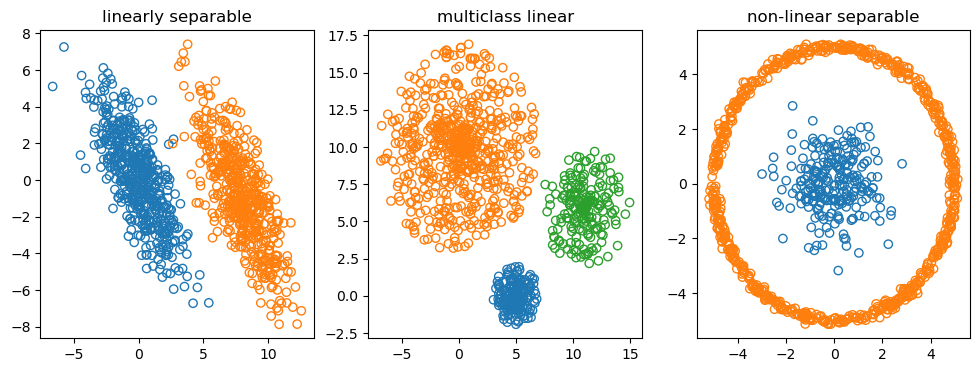

In [3]:
import matplotlib.cm as cm
np.random.seed(4521419)

def plot_hyperplane(model, min_x, max_x, linestyle, label, scaler=None):
    for i in range(len(model.coef_)):
        # get the separating hyperplane
        w = model.coef_[i]
        a = -w[0] / w[1]
        xx = np.linspace(min_x, max_x)  # make sure the line is long enough        
        if scaler:
            xx = (xx-scaler.mean_[0])/scaler.scale_[0]
            yy = a * xx - (model.intercept_[i]) / w[1]
            yy = yy*scaler.scale_[1] + scaler.mean_[1]
            xx = xx*scaler.scale_[0] + scaler.mean_[0]
            print(scaler.mean_)
        else:
            yy = a * xx - (model.intercept_[i]) / w[1]
        plt.plot(xx, yy, linestyle, label=label)

# define rotation function for generating datasets
def rotate(a,angle,mode='degree'):
    if len(a.shape) == 1 or a.shape[1] != 2:
        raise ValueError("ERROR in rotate: input matrix must be Nx2")
    if mode == "angle":
        angle = angle*np.pi/180.0
    return np.einsum('...i,ij',a,np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]))

num = 1000
plt.figure(figsize=(12, 4))

# Generate dataset 1 : offset gaussians (1/2, 1/2 distribution)
a = np.concatenate([np.random.normal(loc=0.0,scale=3.0,size=(int(num/2),1)),np.random.normal(loc=0.0,scale=1.0,size=(int(num/2),1))],axis=1)
a = rotate(a,45) 
b = np.concatenate([np.random.normal(loc=0.0,scale=3.0,size=(int(num/2),1)),np.random.normal(loc=0.0,scale=1.0,size=(int(num/2),1))],axis=1)
b = rotate(b,45) + np.array([8.0,-1.0])
data1_x = np.concatenate([a,b],axis=0)
data1_y = np.array([0]*len(a) + [1]*len(b)) # 0/1 classes
plt.subplot(131)
plt.scatter(data1_x[:,0],data1_x[:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(data1_y)))
plt.title('linearly separable')

# Generate dataset 2 : blobs with varying density (3/5, 1/5, 1/5 distribution)
r = np.random.uniform(low=0.0,high=2.0,size=(int(num/5),1))
theta = np.random.uniform(low=0.0,high=np.pi*2.0,size=(int(num/5),1))
a = np.concatenate([r*np.cos(theta),r*np.sin(theta)],axis=1) + np.array([5.0,0])
r = np.random.uniform(low=0.0,high=7.0,size=(int(num*3/5),1))
theta = np.random.uniform(low=0.0,high=np.pi*2.0,size=(int(num*3/5),1))
b = np.concatenate([r*np.cos(theta),r*np.sin(theta)],axis=1) + np.array([0.0,10.0])
r = np.random.uniform(low=0.0,high=4.0,size=(int(num/5),1))
theta = np.random.uniform(low=0.0,high=np.pi*2.0,size=(int(num/5),1))
c = np.concatenate([r*np.cos(theta),r*np.sin(theta)],axis=1) + np.array([11.0,6.0])
data2_x = np.concatenate([a,b,c],axis=0)
data2_y = np.array([0]*len(a) + [1]*len(b) + [2]*len(c))
plt.subplot(132)
plt.scatter(data2_x[:,0],data2_x[:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(data2_y)))
plt.title('multiclass linear')

# Generate dataset 2 : ring with bullseye (3/4, 1/4 distribution)
a = np.concatenate([np.random.normal(loc=0.0,scale=1.0,size=(int(num/4),1)),np.random.normal(loc=0.0,scale=1.0,size=(int(num/4),1))],axis=1)
r = np.random.normal(loc=5.0,scale=0.1,size=(int(num*3/4),1))
theta = np.random.uniform(low=0.0,high=np.pi*2.0,size=(int(num*3/4),1))
b = np.concatenate([r*np.cos(theta),r*np.sin(theta)],axis=1)
data3_x = np.concatenate([a,b],axis=0)
data3_y = np.array([0]*len(a) + [1]*len(b))
plt.subplot(133)
plt.scatter(data3_x[:,0],data3_x[:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(data3_y)))
plt.title('non-linear separable')


### Error Metrics
Classification is distinguished by unique error metrics for evaluating how our models are performing. In particular, the typical statistical quantities that we care about for regression (e.g., the redi

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Error Metrics Example from Class
y_true = np.array([0,0,0,0,1,1,1,1])
y_pred = np.array([0,0,0,0,1,1,1,0])

print("P: {}".format(precision_score(y_true,y_pred,average=None)))
print("R: {}".format(recall_score(y_true,y_pred,average=None)))
print("A: {}".format(accuracy_score(y_true,y_pred)))
print("f1: {}".format(f1_score(y_true,y_pred,average=None)))

P: [0.8 1. ]
R: [1.   0.75]
A: 0.875
f1: [0.88888889 0.85714286]


In the example above, note that the default behaviors of the various scores is to average over the individual class performances. To get the individual behaviors, we have used the option `average=None`. When run in this way, note that the resulting arrays are indexed to the occurence of a label within the class. 

Note, usually you will want to convert your classes to integers in a classification problem. Scikit learn usually converts string labels behind the scenes to integers for you, but it isn't always consistently supported across various functions. For example, in the cell below we provide a completely equivalent demonstration with string-based classes:

In [5]:
y_true = np.array(["in-spec","in-spec","in-spec","in-spec","out-of-spec","out-of-spec","out-of-spec","out-of-spec"])
y_pred = np.array(["in-spec","in-spec","in-spec","in-spec","out-of-spec","out-of-spec","out-of-spec","in-spec"])

print("P: {}".format(precision_score(y_true,y_pred,average=None)))
print("R: {}".format(recall_score(y_true,y_pred,average=None)))
print("A: {}".format(accuracy_score(y_true,y_pred)))
print("f1: {}".format(f1_score(y_true,y_pred,average=None)))

P: [0.8 1. ]
R: [1.   0.75]
A: 0.875
f1: [0.88888889 0.85714286]


If you use the `average=None` option, as in these examples, you can always calculate the weighted combination of the precision, recall, etc as you see fit. Alternatively, scikit learn supports various averaging options. Two common options are `average = 'macro'`, which calculates the average across the individual classes, and `average = 'binary'`, which only reports the statistic for the positive label (only applies to binary problems, where the positive label is taken to be 1 by default):

In [6]:
# Error Metrics Example from Class
y_true = np.array([0,0,0,0,1,1,1,1])
y_pred = np.array([0,0,0,0,1,1,1,0])

print("P (None) : {}".format(precision_score(y_true,y_pred,average=None)))
print("P (macro): {}".format(precision_score(y_true,y_pred,average='macro')))
print("P (binary): {}".format(precision_score(y_true,y_pred,average='binary')))

print("\nR (None) : {}".format(recall_score(y_true,y_pred,average=None)))
print("R (macro): {}".format(recall_score(y_true,y_pred,average='macro')))
print("R (binary): {}".format(recall_score(y_true,y_pred,average='binary')))



P (None) : [0.8 1. ]
P (macro): 0.9
P (binary): 1.0

R (None) : [1.   0.75]
R (macro): 0.875
R (binary): 0.75


A final option that may be useful is `zero_division = 0`. In multiclass cases if true positives, true negatives, etc are 0, you may get 0/0 behavior in the calculation of the statistic. Default behavior is to set these cases to 0, but it prints a warning. When you use `zero_division = 0`, it will also set these cases to 0, but it suppresses the warning. You can also set this option to 1 if that is how you want these cases to be treated.  

### Predicting the Mean/Majority ###
If you recall, a useful reference for the performance of regression models, is comparison with predicting the mean. That is, the most naive model in the context of regression is one that just always returns the mean value from the training data. The corresponding baseline for classification models is a model that always predicts the most prevalent category in the dataset. For our three toy datasets let's illustrate the relative performance of predicting the majority on the various datasets:  

In [ ]:
from collections import Counter

# Show distribution of labels
data1_counts = Counter(data1_y).most_common()
data2_counts = Counter(data2_y).most_common()
data3_counts = Counter(data3_y).most_common()
print("data1 labels: {}".format(data1_counts))
print("data2 labels: {}".format(data2_counts))
print("data3 labels: {}".format(data3_counts))

# Calculate the majority label in each dataset
data1_maj = data1_counts[0][0]
data2_maj = data2_counts[0][0]
data3_maj = data3_counts[0][0]
print("\nmajority (data1): {}".format(data1_maj))
print("majority (data2): {}".format(data2_maj))
print("majority (data3): {}".format(data3_maj))

# Check accuracy from predicting the majority label
data1_pred = np.array([data1_maj]*len(data1_y))
data2_pred = np.array([data2_maj]*len(data2_y))
data3_pred = np.array([data3_maj]*len(data3_y))
print("\nA (data1): {}".format(accuracy_score(data1_y,data1_pred)))
print("A (data2): {}".format(accuracy_score(data2_y,data2_pred)))
print("A (data3): {}".format(accuracy_score(data3_y,data3_pred)))

data1 labels: [(0, 500), (1, 500)]
data2 labels: [(1, 600), (0, 200), (2, 200)]
data3 labels: [(1, 750), (0, 250)]

majority (data1): 0
majority (data2): 1
majority (data3): 1

A (data1): 0.5
A (data2): 0.6
A (data3): 0.75


In this case we have used the helpful `Counter` function from the `collections` library, which creates a dictionary with each distinct object in an iterable as the key and the counts for that object within the iterable as the value. 

Is it surprising that the accuracies are different for the different despite the fact that they all predict the majority? No, because we can also see that the datasets have distinct balances among the classes, with `data1` being equally balanced, and the other two being unbalanced. This is the purspose behind different averaging schemes for determining "accuracy", "precision", etc. The so-called `balanced accuracy` is one common scheme for addressing data imbalances with respect to the accuracy statistic. In the simplest case, it averages the individual accuracies for each distinct label. For illustration, let's look at what scikit-learn's `balanced_accuracy_score` predicts in these cases:

In [8]:
from sklearn.metrics import balanced_accuracy_score
print("A (data1): {}".format(balanced_accuracy_score(data1_y,data1_pred)))
print("A (data2): {}".format(balanced_accuracy_score(data2_y,data2_pred)))
print("A (data3): {}".format(balanced_accuracy_score(data3_y,data3_pred)))

A (data1): 0.5
A (data2): 0.3333333333333333
A (data3): 0.5


In the `data1` case, the accuracy for label 0 is 100% but the accuracy for label 1 is 0%, so the average of those is 50% (i.e., same as regular accuracy statistic since the dataset is balanced). 

In the `data2` case, the accuracy for label 1 is 100% but the accuracy for labels 0 and 2 are 0%, so the average of those is 33%.

In the `data3` case, the accuracy for label 1 is 100% but the accuracy for label 0 is 0%, so the average of those is 50%. In this case, the balanced accuracy of 50% is lower than the regular accuracy statistic (75%) because it corrects for the data imbalance. 

## Logistic Regression
Logistic regression is the simplest linear model capable of classification. The strategy is to turn the discreet classification problem into a continuous problem (i.e., regression) by trying to predict the probability of a label instead of the label itself. 

However, the model predicts the log(p) as being linear rather than predicting the probability as being linear. This gives the model the correct form (i.e., a sigmoidal function of varying type depending on the base of the logarithm that you use) for predicting probability. Namely, sigmoidal functions are bound from 0-1, which makes sense for predicting probability. If you just modeled the probability itself as being linearly dependent on $\mathbf{x}$, then you would get regions with $y>1$ and $y<1$. However, the fact that the log(p) is modeled as linear with respect to x limits the model to predicting classes that are linearly separated in $mathbf{x}$ (i.e., separated by a line, or hyperplane in higher dimensions). In addition, there is no closed form analytical solution to logistic regression loss functions, so they require numerical optimization to train even though they are fundamentally linear models. 

The relevant scikit-learn class for logistic regression is `sklearn.linear_model.LogisticRegression`. Among the important variables are:

`penalty`: this controls the regularization to use (L2 by default)
`tol`: determines the stopping criteria for the numerical optimization (1E-4 by default)
`max_iter`: the stopping criteria for the number of iterations to perform (100 by default)

Note: logistic regression can be sensitive to data scaling, so it is usually advisable to standardize your data. We'll illustrate this in the example below with the helper function from scikitlearn


D1 Summary Statistics:
P: 0.999001996007984
R: 0.999
A: 0.999
f1: 0.998999998999999


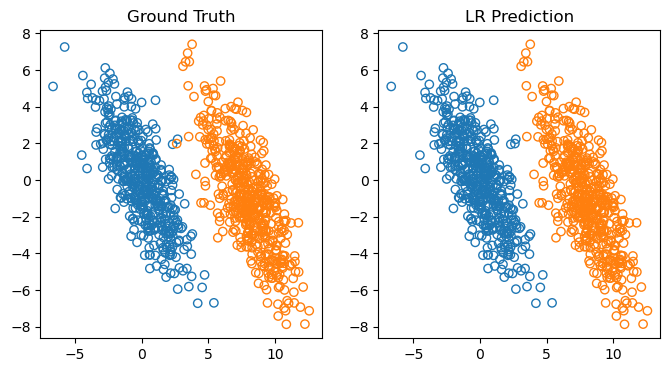

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


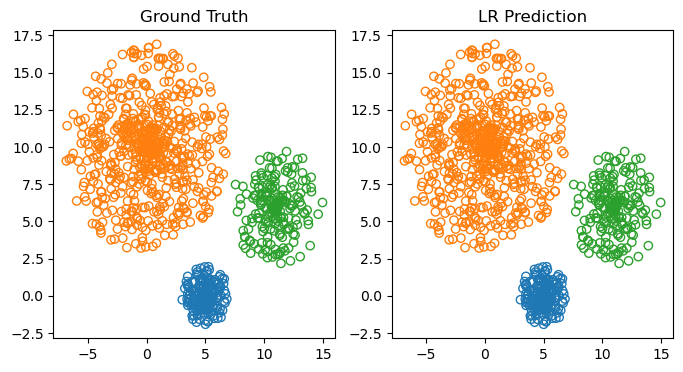

D3 Summary Statistics:
P: 0.375
R: 0.5
A: 0.5
f1: 0.42857142857142855


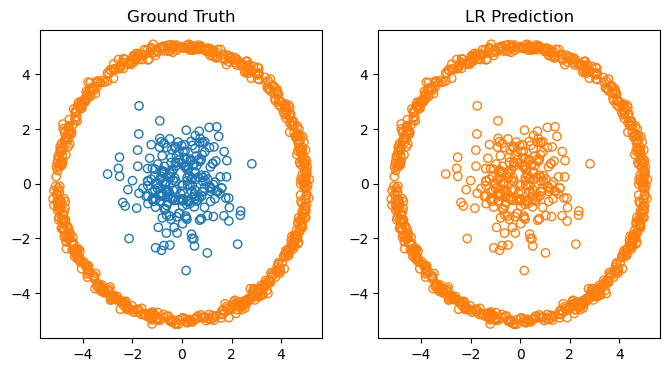

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

datasets = {"D1":(data1_x,data1_y), "D2":(data2_x,data2_y), "D3":(data3_x,data3_y)}

for i in datasets.keys():
    
    # Initialize LR model and fit to standardized data
    model = LogisticRegression()
    scaler = StandardScaler().fit(datasets[i][0]) # object that standardizes data
    model.fit(scaler.transform(datasets[i][0]),datasets[i][1])
    y_pred = model.predict(scaler.transform(datasets[i][0]))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')

    # Plot LR predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(scaler.transform(datasets[i][0]))))
    plt.title('LR Prediction')
    
    plt.show()

A few comments on the implementation here. We have used the `sklearn.preprocessing.StandardScaler` object to standardize the x-values before training each model. We save the scaler object so that we can use the `scalar.transform()` method to transform new x-values by the same amount as the training data when making predictions on new data. In the current case, this is overkill, because we don't actually have any testing data, but I want you to see the workflow.

In the first example, you can see the way that logistic regression effectively creates linear boundaries in x-space by looking at the orange datapoint that is in the blue region. The model essentially draws a line, and everything to the left becomes blue and to the right becomes orange. In the second example, there are no overlaps between the regions, so the prediction is perfect. We can also see the limitations of using a linear model in the last example. The third case fails completely because there is no linear boundary to separate the data along.  


## Support Vector Machines ##
<b>Support vector machines</b> are a common model for supervised classification tasks. After covering the details you will also see on a variation of SVM could be used for unsupervised classification, which provides a nice bridge between the supervised and unsupervised learning lectures. 

The object SVMs is to identify the optimal boundary that separates two or more classes of objects with respect to the descrptors. That is, an SVM, like all supervised classification models attempts to solve the problem $\mathbf{y} = f(\mathbf{x})$ such that given a future x, we predict the correct class y to apply to the observation. In this case, SVM draws a <i>linear</i> boundary between the two classes. That is, if you plot the data classes with respect to <b>x</b>, the SVM solution is represented by the "best" straight line that divides them. The ability to draw such a boundary will clearly depend on your choice of <b>x</b>! 

A few questions that should have arisen if you understood the last paragraph:

1. <b>What if we have more than two classes?</b> It turns out that this problem can be solved by reducing it to several pair-wise classification problems. So understanding the two class case is the correct starting point. 

2. <b>What if the classes overlap?</b> The typical objective function for training SVMs utilizes a "soft" boundary that linearly penalizes observing a label in the wrong region. In this case the "best" line, will still have errors in training. 

3. <b>What if the line separating the classes is not straight?</b> When the best boundary between your classes is anything but a straight line, that means your problem is "non-linear" in your chosen <b>x</b> descriptors. You may be able to find better descriptors that linearize the problem. More likely you are stuck with <b>x</b>. But you may still be able to linearize the boundary using the "kernel trick", which transforms your <b>x</b> into a higher dimension where the problem becomes linear. This is cool stuff, but beyond what we can cover here.   

4. <b>What is a support vector?</b> Since all a SVM is trying to do is find a boundary, it turns out the optimal solution only depends on the samples that are at the edge of the domain. The vectorial positions of these boundary data are the "support vectors" and hence the name of the model. 
The cell below demonstrates how to use the scikit-learn `SVC` object to perform linear classification:

D1 Summary Statistics:
P: 0.998
R: 0.998
A: 0.998
f1: 0.998


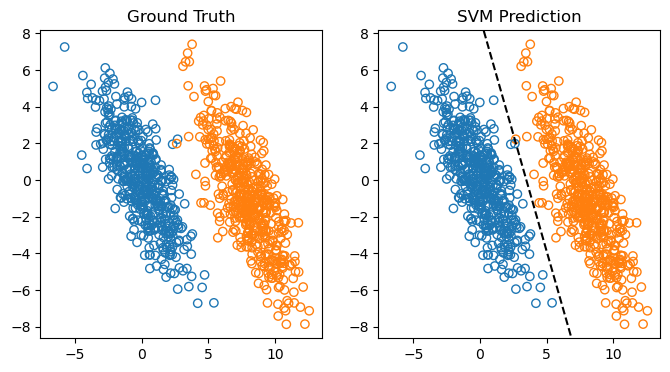

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


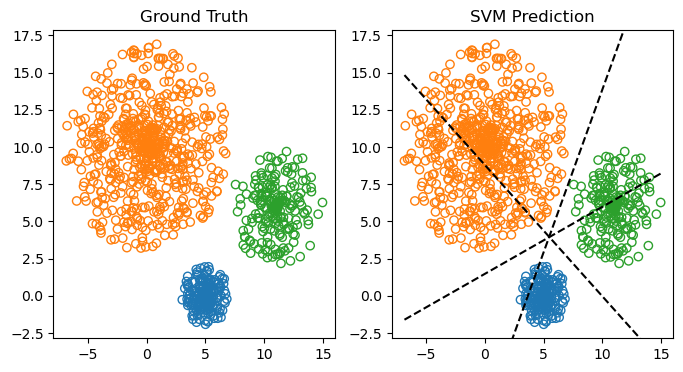

D3 Summary Statistics:
P: 0.375
R: 0.5
A: 0.5
f1: 0.42857142857142855


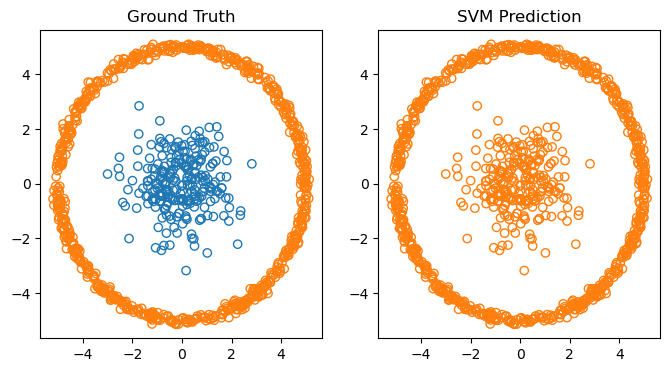

In [10]:
from sklearn.svm import SVC

datasets = {"D1":(data1_x,data1_y), "D2":(data2_x,data2_y), "D3":(data3_x,data3_y)}

for i in datasets.keys():
    
    # Initialize SVC model and fit 
    model = SVC(kernel='linear')
    model.fit(datasets[i][0],datasets[i][1])
    y_pred = model.predict(datasets[i][0])
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')
    xlim = plt.xlim()
    ylim = plt.ylim()
    
    # Plot SVM predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(datasets[i][0])))
    plt.title('SVM Prediction')
    plot_hyperplane(model, min(datasets[i][0][:,0]), max(datasets[i][0][:,0]), 'k--','Boundary\nfor class 1')
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.show()

<b>Note:</b> In this case we didn't standardize the features, just because it makes it easier to plot the hyperplanes from the SVM fit. In general, you do want to standardize features when using SVMs. 

<b>Note:</b> It is messy to try and draw the boundaries so that they don't overlap. Technically, the dotted lines should radiate out from the crossings, not pass through it. 

Since SVMs are linear models, we good behavior in the linear cases, but complete failure in the non-linear case. 

### Kernel Trick ###
The so-called "kernel trick" is used for linearizing non-linear problems. In simple terms this let's you determine curved boundaries with SVMs. In principle these are very expensive to calculate, but by applying the transform virtually (via the kernel) these curved boundaries can be calculated very effectively. The results will depend on the specific Kernel that you use. Options supported by scikit-learn are `kernel=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’` which are what they sound like, besides `rbf` which is a radial basis function (good for cylindrical or spherical type boundaries), and `precomputed` which allows you to calculate your own kernel and pass the transformed $\mathbf{x}$. The `poly` kernel also uses the `degree` variable to determine the order of the polynomial to use in the transform. 

In the cell below, let's see if any of these kernels can solve our non-linear toy problem:

linear Summary Statistics:
P: 0.375
R: 0.5
A: 0.5
f1: 0.42857142857142855


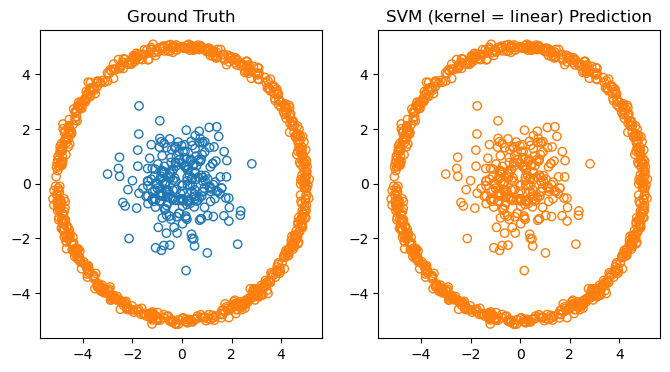

poly Summary Statistics:
P: 0.375
R: 0.5
A: 0.5
f1: 0.42857142857142855


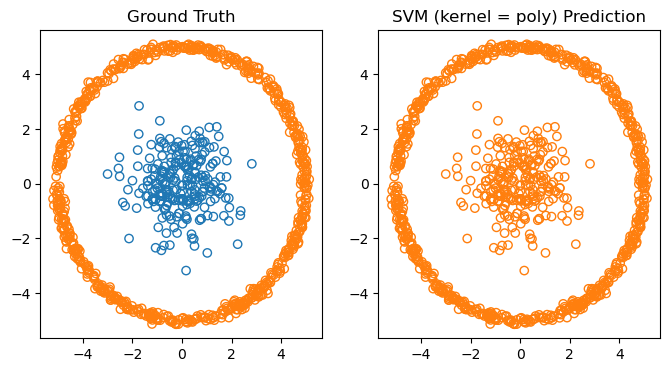

rbf Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


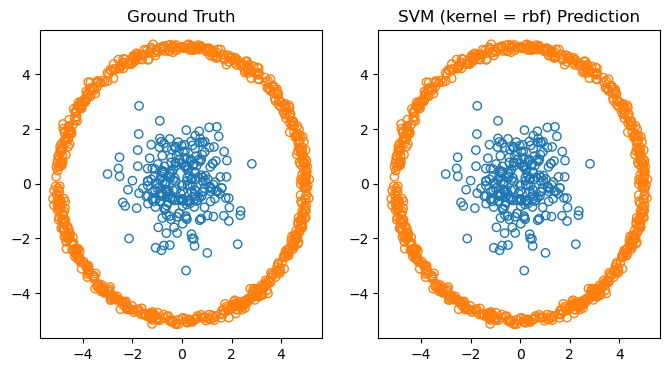

sigmoid Summary Statistics:
P: 0.3368146214099217
R: 0.344
A: 0.344
f1: 0.3403693931398417


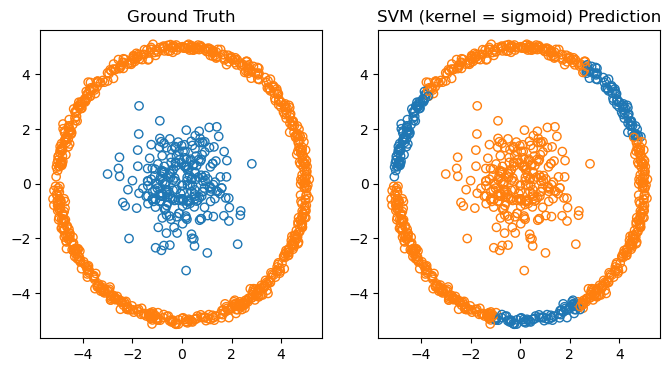

In [11]:
for i in ['linear','poly','rbf','sigmoid']:
    
    # Initialize SVC model and fit to standardized data
    model = SVC(kernel=i)
    model.fit(datasets["D3"][0],datasets["D3"][1])
    y_pred = model.predict(datasets["D3"][0])
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets["D3"][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets["D3"][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets["D3"][1],y_pred)))
    print("f1: {}".format(f1_score(datasets["D3"][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets["D3"][0][:,0],datasets["D3"][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets["D3"][1])))
    plt.title('Ground Truth')
    xlim = plt.xlim()
    ylim = plt.ylim()
    
    # Plot SVM predictions
    plt.subplot(122)
    plt.scatter(datasets["D3"][0][:,0],datasets["D3"][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(datasets["D3"][0])))
    plt.title('SVM (kernel = {}) Prediction'.format(i))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.show()

As expected, the radial basis function kernel is the best for this problem, given the obvious radial symmetry. More generally, multiple kernels are experimented with, and custom kernels are commonly used for specific problems. 

## Nearest neighbors ##
Nearest neighbor methods are a non-parametric, or 'model-free' algorithm for classifying data. The idea is that instead of training a model, predictions are simply based on the nearest set of points in the training data. The two most common methods are <b>k-nearest neighbors</b> (KNN), which uses majority label from the `k` nearest-neighbors from the training data to make predictions, and <b>radical nearest neighbors</b> (RNN), which uses the majority label from points within a user specified radius. Each method supports multiple distance measures. 

The relevant scikit-learn class for KNN classification is `sklearn.neighbors.KNeighborsClassifier`. Among the important variables are:

`k`: this controls the number of neighbors to base the prediction on (5 by default)
`metric`: determines the distance metric for determining closest neighbors (euclidian by default)

The relevant scikit-learn class for RNN classification is `sklearn.neighbors.RadiusNeighborsClassifier`. Among the important variables are:

`radius`: this controls the radius threshold for finding neighbors (1 by default, obviously problem/standardization specific)
`metric`: determines the distance metric for determining closest neighbors (euclidian by default)

We illustrate these methods in the cell below:

D1 Summary Statistics:
P: 0.999001996007984
R: 0.999
A: 0.999
f1: 0.998999998999999


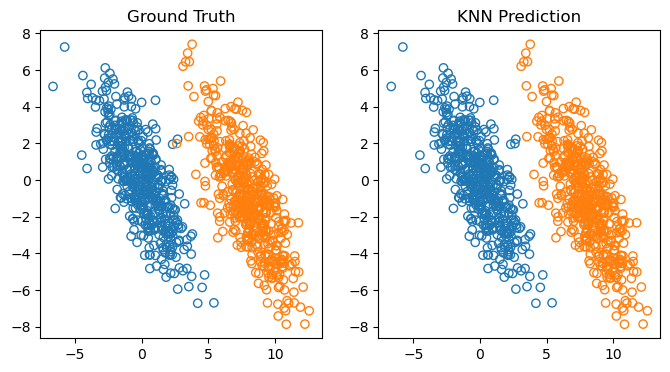

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


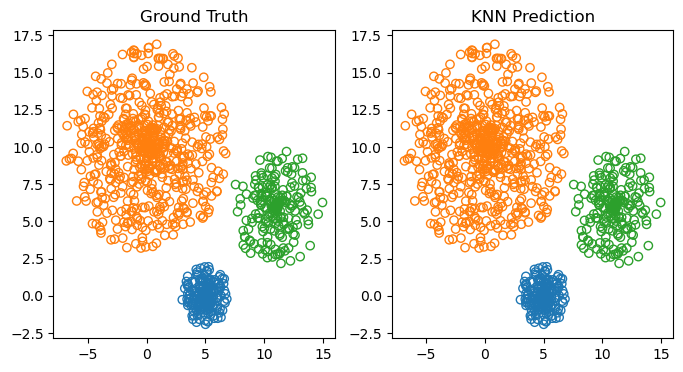

D3 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


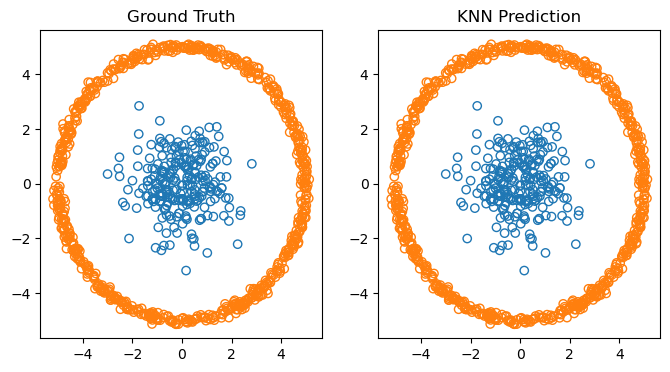

D1 Summary Statistics:
P: 0.999001996007984
R: 0.999
A: 0.999
f1: 0.998999998999999


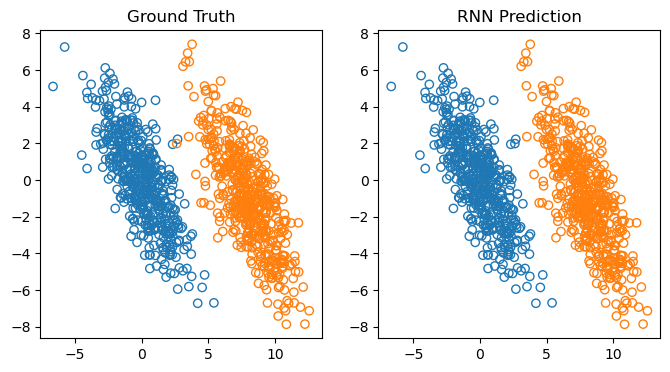

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


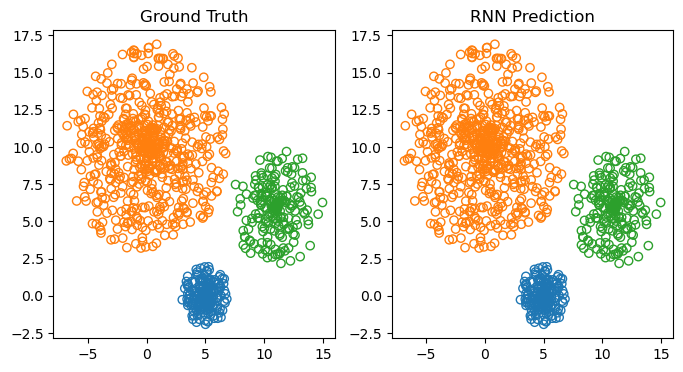

D3 Summary Statistics:
P: 0.996031746031746
R: 0.988
A: 0.988
f1: 0.9919350936335629


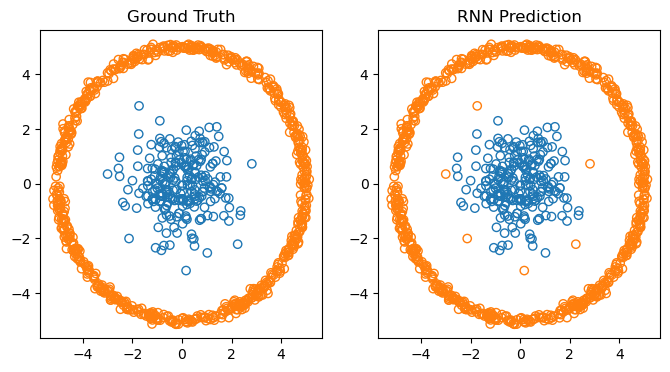

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

datasets = {"D1":(data1_x,data1_y), "D2":(data2_x,data2_y), "D3":(data3_x,data3_y)}

# KNN Loop
for i in datasets.keys():
    
    # Initialize KNN model and fit to standardized data
    model = KNeighborsClassifier()
    scaler = StandardScaler().fit(datasets[i][0]) # object that standardizes data
    model.fit(scaler.transform(datasets[i][0]),datasets[i][1])
    y_pred = model.predict(scaler.transform(datasets[i][0]))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')

    # Plot KNN predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(scaler.transform(datasets[i][0]))))
    plt.title('KNN Prediction')
    
    plt.show()

# RNN Loop
for i in datasets.keys():
    
    # Initialize RNN model and fit to standardized data
    model = RadiusNeighborsClassifier()
    scaler = StandardScaler().fit(datasets[i][0]) # object that standardizes data
    model.fit(scaler.transform(datasets[i][0]),datasets[i][1])
    y_pred = model.predict(scaler.transform(datasets[i][0]))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')

    # Plot RNN predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(scaler.transform(datasets[i][0]))))
    plt.title('RNN Prediction')
    
    plt.show()


Although extremely simple, these algorithms perform very well on these toy problems. The last example shows some of the fine-tuning involved when your data has varying density. Namely, depending on whether you are using radial or k-nearest neighbors, it may be the case that even if your clusters are well separated some of the points may be classified as belonging to a neighboring cluster. 

## Decision Trees ##
For completeness, let's see how decision trees do on our problems. Given the additional expressibility of decision trees, we would anticipate that they can trivially carve up the x-space to perfectly predict these datasets. However, in general they have the same overfitting challenge as for regression problems. To illustrate this, we will split our data and only use half to train the trees. 

D1 Summary Statistics:
P: 0.9970178926441352
R: 0.997
A: 0.997
f1: 0.996999972999757


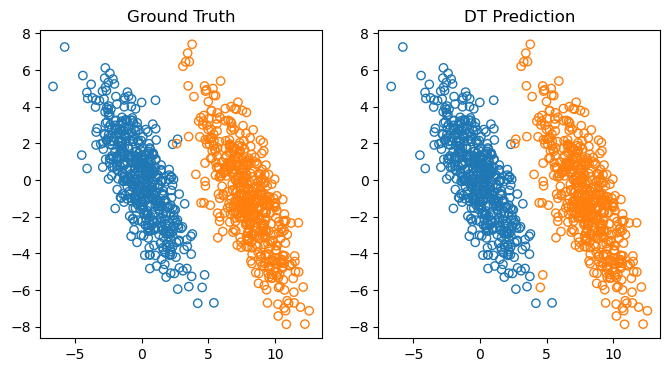

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


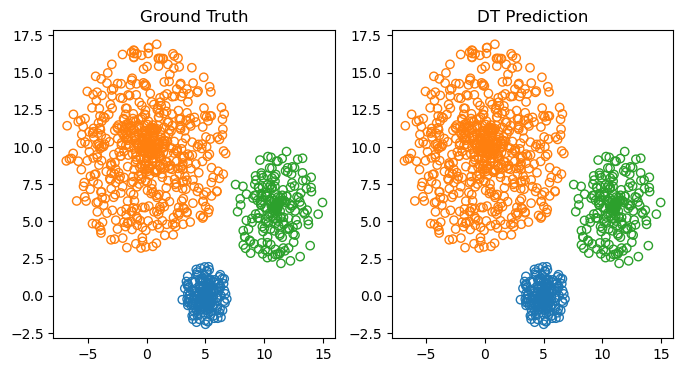

D3 Summary Statistics:
P: 0.9833222353408576
R: 0.9606666666666667
A: 0.9606666666666667
f1: 0.9713393138631738


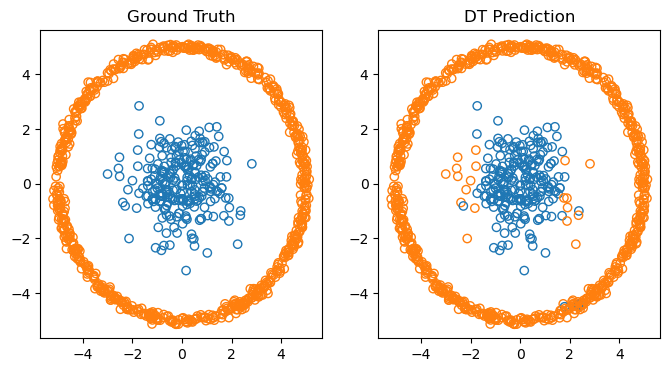

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

datasets = {"D1":(data1_x,data1_y), "D2":(data2_x,data2_y), "D3":(data3_x,data3_y)}

for i in datasets.keys():
    
    # Make the split
    x_train, x_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.5,random_state=135323)

    # Initialize DT model and fit to standardized data
    model = DecisionTreeClassifier()
    scaler = StandardScaler().fit(x_train) # object that standardizes data
    model.fit(scaler.transform(x_train),y_train)
    y_pred = model.predict(scaler.transform(datasets[i][0]))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')

    # Plot DT predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(scaler.transform(datasets[i][0]))))
    plt.title('DT Prediction')
    
    plt.show()


We used the default hyperparameters for training these trees, which has the tendency of overfitting them. In these cases we can see several obvious errors that arises from the fact that we are only training on half the data and overfitting. 

## Random Forests ##
Finally, let's revisit random forests for this problem. Since it is low dimensional, the difference with decision trees will be less apparent, but we can likely get some advantage out of the bootstrap resampling. 

D1 Summary Statistics:
P: 0.999001996007984
R: 0.999
A: 0.999
f1: 0.998999998999999


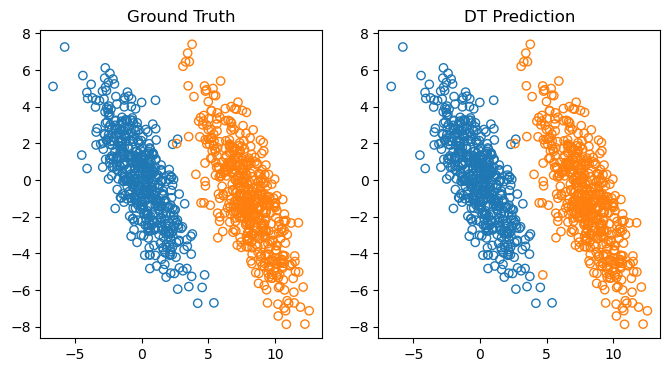

D2 Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


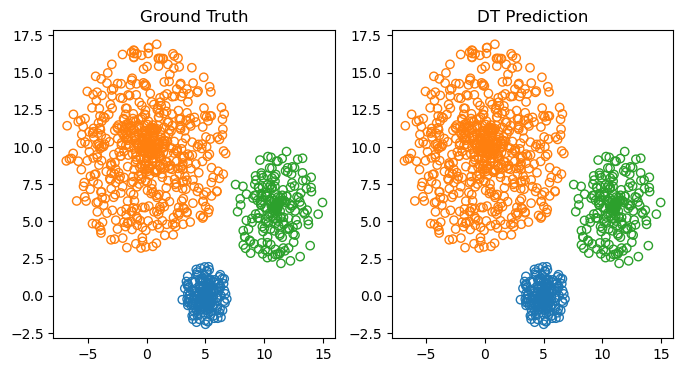

D3 Summary Statistics:
P: 0.9921259842519685
R: 0.976
A: 0.976
f1: 0.9837366640645329


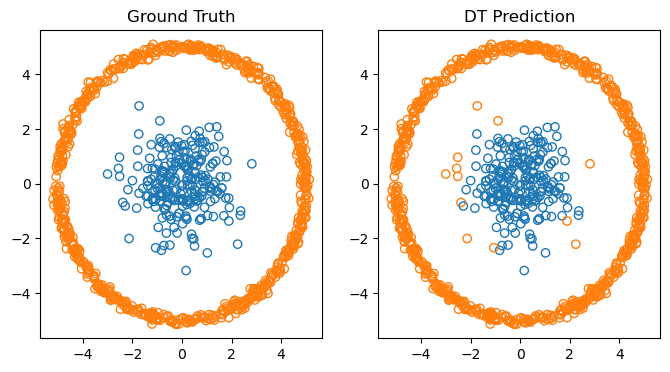

In [14]:
from sklearn.ensemble import RandomForestClassifier

datasets = {"D1":(data1_x,data1_y), "D2":(data2_x,data2_y), "D3":(data3_x,data3_y)}

for i in datasets.keys():
    
    # Make the split
    x_train, x_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.5,random_state=135323)

    # Initialize DT model and fit to standardized data
    model = RandomForestClassifier(n_estimators=100)
    scaler = StandardScaler().fit(x_train) # object that standardizes data
    model.fit(scaler.transform(x_train),y_train)
    y_pred = model.predict(scaler.transform(datasets[i][0]))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(datasets[i][1],y_pred)))
    print("f1: {}".format(f1_score(datasets[i][1],y_pred,average='macro',zero_division=0)))
    
    # Plot original data with labels
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(list(datasets[i][1])))
    plt.title('Ground Truth')

    # Plot DT predictions
    plt.subplot(122)
    plt.scatter(datasets[i][0][:,0],datasets[i][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model.predict(scaler.transform(datasets[i][0]))))
    plt.title('DT Prediction')
    
    plt.show()


We can see some marginal improvement in error statistics, and in the first case, in particular, the random misclassifications from overfitting are removed. 

## Equipment Failure Dataset ##
Now let's test our various algorithms out on a more sophisticated problem. We'll be looking at a dataset consisting of some features of a pump with labels corresponding to an expert classification of whether the pump is passing, failing, or should be reworked. The files `features.txt` and `labels.txt` hold our X and y for this problem. 

In [15]:
features = pd.read_csv('features.txt', delimiter=r"\s+")
labels = pd.read_csv('labels.txt',header=None)
print(features)
print(labels)

     Inlet_Diameter_(cm)  Maximum_Capacity_(GPM)  Max_Head_(ft)  \
0              14.929424             14648.58271     540.786540   
1              15.211007             14610.50485     541.758763   
2              15.179786             14793.60688     541.575416   
3              15.099801             14705.36420     541.606790   
4              15.271154             14760.58303     542.322036   
..                   ...                     ...            ...   
145            16.100000             14603.73416     543.127255   
146            16.090268             14672.80768     542.998629   
147            16.061262             14779.53401     543.585908   
148            16.013545             14857.83103     544.341088   
149            15.948048             14975.00756     542.717648   

     Minimum_Thickness_(mm)  
0                 10.358895  
1                 10.789250  
2                 10.816944  
3                 10.055267  
4                 10.770059  
..             

Glancing at the data, we can see that there are 4 features related to the pump specs, and a corresponding classification from an expert that inspected the pump. There are three classes, `P="pass"`, `R="rework"`, `F="fail"`. We expect our pump to operate within a certain set of tolerances. If the inlet diameter is too small or too large, it can adversely affect the pump capacity. Within the acceptable inlet diameter range, we can accept some fluctuation in capacity. If the maximum head (analagous to maximum pressure) is very high but the minimum thickness of the pump is too small, the pump will fail.

Let's also take a look at our data and calculate some summary statistics:

       Inlet_Diameter_(cm)  Maximum_Capacity_(GPM)  Max_Head_(ft)  \
count           150.000000              150.000000     150.000000   
mean             15.135587            14700.096623     542.923830   
std               0.481500              189.738274       1.516724   
min              14.102436            14258.800630     539.369207   
25%              14.862139            14611.595240     541.828181   
50%              15.097686            14683.594165     542.949154   
75%              15.470908            14798.056495     544.047032   
max              16.100000            15162.585260     546.154856   

       Minimum_Thickness_(mm)  
count              150.000000  
mean                10.342815  
std                  0.472594  
min                  9.273588  
25%                 10.060062  
50%                 10.343106  
75%                 10.692270  
max                 11.427964  


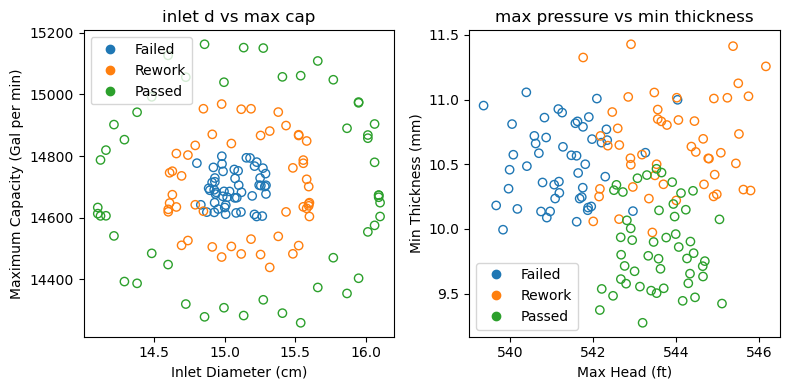

In [16]:
import matplotlib.lines as mlines

# print out summary statistics for each feature
print(features.describe())

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make the data arrays
X = features.to_numpy()
label_dict = { i:count_i for count_i,i in enumerate(set(labels[0])) }
Y = np.array([ label_dict[_] for _ in labels[0] ])


# Make plots
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()

A couple things should jump out at you. First, we have a non-linear problem in at least two of the variables. It is possible that in 4d some hyperplane splits the data, but from our two-dimensional projections it doesn't look great. Second, the ranges, means, and variances vary a lot across the features. We should definitely standardize the features before training our models.

Let's do some pre-processing to generate a training/testing split and convert the string labels into integers. 

In [17]:
# Generate the training/testing split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=135323)

print(x_train.shape)
print(X.shape)

(120, 4)
(150, 4)


We have converted the string-labels to integers to facilitate the training and plotting of the results. For later conversion back to the labels, we've also kept a dictionary of the string-to-integer conversions. 

Due to the limited data that is available, we have used a relatively small testing split here. A good exercise for you is to redo this example using a larger testing split, but training the models using cross-validation for hyperparameter selection.

Now let's compare our various classification models:

LR Summary Statistics:
P: 0.8934065934065935
R: 0.8910256410256411
A: 0.8910256410256411
f1: 0.890148448043185


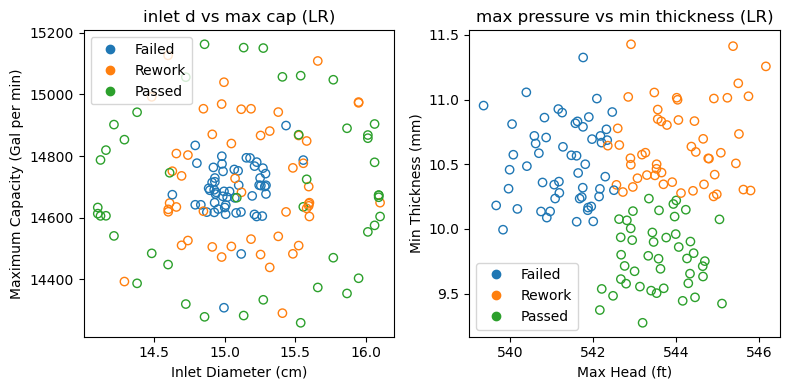

SVM Summary Statistics:
P: 0.9629629629629629
R: 0.9743589743589745
A: 0.9743589743589745
f1: 0.9670588235294119


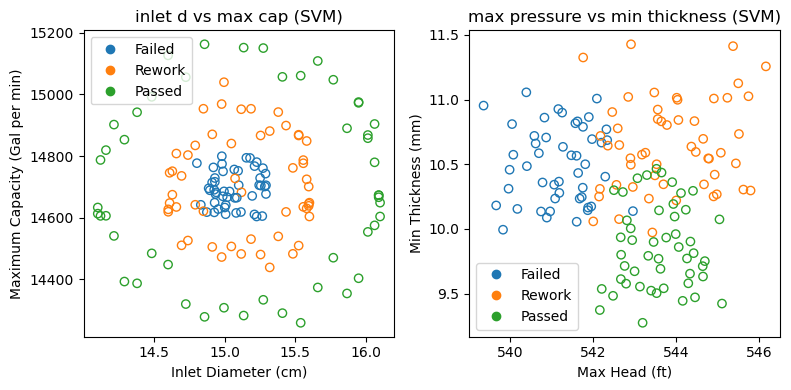

KNN Summary Statistics:
P: 0.8560606060606061
R: 0.8653846153846154
A: 0.8653846153846154
f1: 0.8555555555555555


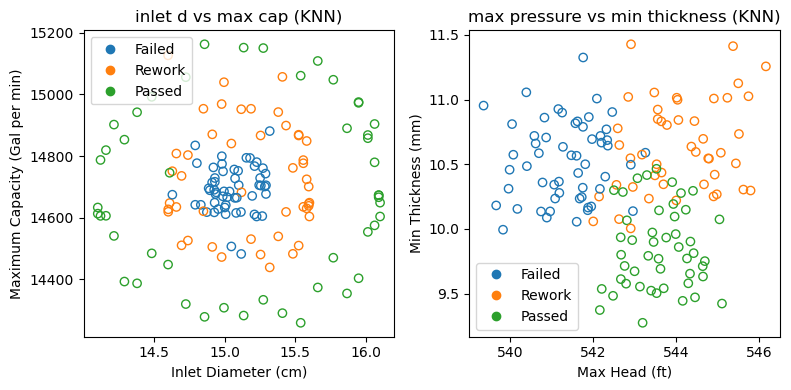

DT Summary Statistics:
P: 0.8214285714285715
R: 0.8237179487179488
A: 0.8237179487179488
f1: 0.8134920634920634


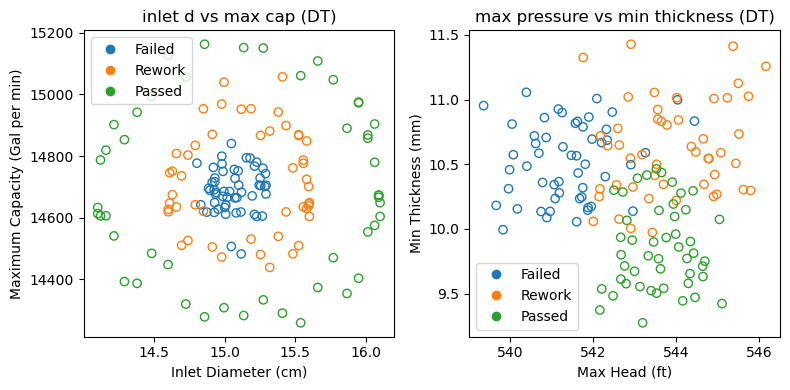

RF Summary Statistics:
P: 0.9629629629629629
R: 0.9743589743589745
A: 0.9743589743589745
f1: 0.9670588235294119


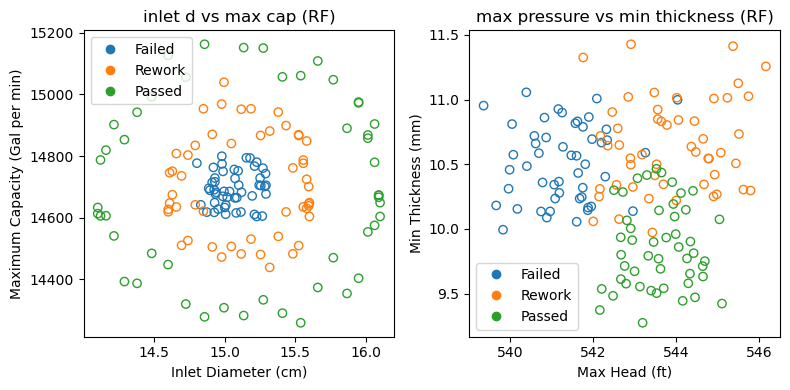

In [18]:
models = { "LR": LogisticRegression(),\
           "SVM": SVC(kernel='rbf'),\
           "KNN": KNeighborsClassifier(),\
           "DT": DecisionTreeClassifier(),\
           "RF": RandomForestClassifier(n_estimators=1000) }

# Initialize scalar object for features
scaler = StandardScaler().fit(x_train)

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Loop over the models and train them
for i in models.keys():
    
    # fit the model to the training data
    models[i].fit(scaler.transform(x_train),y_train)
    y_pred = models[i].predict(scaler.transform(x_test))
    print("{} Summary Statistics:".format(i))
    print("P: {}".format(precision_score(y_test,y_pred,average='macro',zero_division=0)))
    print("R: {}".format(recall_score(y_test,y_pred,average='macro',zero_division=0)))
    print("A: {}".format(balanced_accuracy_score(y_test,y_pred)))
    print("f1: {}".format(f1_score(y_test,y_pred,average='macro',zero_division=0)))

    # Make plots with predictions over the whole dataset (y_all; testing and training combined)
    y_all = models[i].predict(scaler.transform(X))
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(y_all))
    plt.xlabel("Inlet Diameter (cm)")
    plt.ylabel("Maximum Capacity (Gal per min)")
    plt.title('inlet d vs max cap ({})'.format(i))
    plt.legend(handles=[fail,rework,passed])

    plt.subplot(122)
    plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(y_all))
    plt.xlabel("Max Head (ft)")
    plt.ylabel('Min Thickness (mm)')
    plt.title('max pressure vs min thickness ({})'.format(i))
    plt.legend(handles=[fail,rework,passed])
    plt.tight_layout()
    plt.show()    
